In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
disease_map=pd.DataFrame( ['Zeller_fecal_colorectal_cancer',
                         'Quin_gut_liver_cirrhosis',
                         'metahit',
                         't2dmeta_long',
                         'WT2D',
                         'Chatelier_gut_obesity'], 
             ['Colorectal', 'Cirrhosis', 'IBD', 'C-T2D', 'EW-T2D', 'Obesity'] 
            ).reset_index()

disease_map.columns = ['clean', 'raw']

In [3]:
all_results=pd.concat( [pd.read_csv('results/'+a) for a in os.listdir('results') if a[-3:]=='csv'], axis=0)
all_results=all_results.merge(disease_map, left_on='Dataset', right_on='raw'
                 )[['Data Type', 'clean', 'Model Type', 'hyperparams','AUC']]
all_results.columns=['Data Type', 'Dataset', 'Model Type', 'Hyperparameters','AUC']                  
all_results=all_results.reset_index(drop=True)
all_results.head()

,Data Type,Dataset,Model Type,Hyperparameters,AUC
0,Marker,Colorectal,SAE,"[128, 'rf']",0.688889
1,Abundance,Colorectal,RF,"[300, 3, 'gini']",0.674074
2,Abundance,Colorectal,SAE,"[64, 'rf']",0.837037
3,Abundance,Colorectal,SVM,"[-1, -15]",0.288889
4,Abundance,Colorectal,FFNN,"[256, 64, 64, 0.1, 0.5]",0.718519


In [4]:
all_results

,Data Type,Dataset,Model Type,Hyperparameters,AUC
0,Marker,Colorectal,SAE,"[128, 'rf']",0.688889
1,Abundance,Colorectal,RF,"[300, 3, 'gini']",0.674074
2,Abundance,Colorectal,SAE,"[64, 'rf']",0.837037
3,Abundance,Colorectal,SVM,"[-1, -15]",0.288889
4,Abundance,Colorectal,FFNN,"[256, 64, 64, 0.1, 0.5]",0.718519
...,...,...,...,...,...
67,Abundance,Obesity,DAE,"[64, 32, 'rf']",0.700692
68,Abundance,Obesity,VAE,"[256, 16, 'rf']",0.586505
69,Marker,Obesity,VAE,"[32, 16, 'svm']",0.576125
70,Marker,Obesity,RF,"[500, 5, 'gini']",0.543253


In [5]:
all_results['Model Type'].value_counts()

DAE     12
RF      12
VAE     12
FFNN    12
SVM     12
SAE     12
Name: Model Type, dtype: int64

In [6]:
#all_results=all_results.loc[all_results['Model Type']!='FFNN']

In [7]:
all_results[['Data Type', 'Dataset', 'Model Type', 'Hyperparameters','AUC']].sort_values('AUC', 
    ascending=False).groupby(['Data Type', 'Dataset']).head(1).sort_values(['Data Type','Dataset'],
        ascending=False)

,Data Type,Dataset,Model Type,Hyperparameters,AUC
71,Marker,Obesity,FFNN,"[128, 256, 32, 0.001, 0.3]",0.773356
29,Marker,IBD,DAE,"[1024, 64, 'svm']",0.952941
48,Marker,EW-T2D,SAE,"[64, 'svm']",0.949495
11,Marker,Colorectal,FFNN,"[128, 256, 64, 0.001, 0.5]",0.881481
23,Marker,Cirrhosis,FFNN,"[256, 64, 128, 0.001, 0.3]",0.954710
47,Marker,C-T2D,FFNN,"[1024, 256, 32, 0.001, 0.3]",0.773109
61,Abundance,Obesity,RF,"[100, 1, 'gini']",0.756920
25,Abundance,IBD,RF,"[900, 3, 'gini']",0.835294
49,Abundance,EW-T2D,RF,"[300, 3, 'gini']",0.838384
8,Abundance,Colorectal,VAE,"[32, 8, 'rf']",0.896296


a few thoughts:
- the RF model is doing the best on the abundance data. This is consistent with their resutls
- I have the deep FFNN doing the best on the marker data 4/6 times. This isn't the same as their output, as they didn't really look too deeply into ffnns. This suggests that for my project, I could potentially get more out of the FFNNs than the encoders when it comes to transfer learning.... could be wrong, but shouldn't be surprised if the final results call for FFNNs to be the main focus. FFNNs had a particularly large improvement for the marker CRC dataset. 

- generally, the aucs I have are within DeepMicro's uncertainty range. It's possible they were a little more stringent with how they defined a disease from the tables. 
- My FFNN is doing much better than their MLP model. This could be due to differences in design.
- biggest difference in results is from the CRC data. They seem to get much worse results because they consider adenomas to be negative, while I treat it as positive. Given that it makes the results much better, there is value in this. Furthermore, from a CRC screening perspective, the detection of adenomas in the colon can often classify patients as 'high risk', and it often should warrant a colonoscopy (or at least a visit to a GE). 

In [8]:
def plot_fig2_summary(data, 
                      axis,
                      dataset,
                      data_type, 
                      i
                      ):
    

    df = data.loc[( data['Dataset']==dataset)&(
                    data['Data Type']==data_type)]
    
    df=df.sort_values('Model Type', axis=0)
    sns.barplot(x='Model Type', 
                y='AUC', 
                data=df, 
                ax=axis)
    #axis.get_legend().remove()
    axis.set_title(dataset, size=20)
    axis.set_ylim(0, 1.03)
    axis.set_xlabel(None)
    if i in [0,3]:
        axis.set_ylabel('AUC')
    else:
        axis.set_ylabel(None)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(font_scale = 1.5)

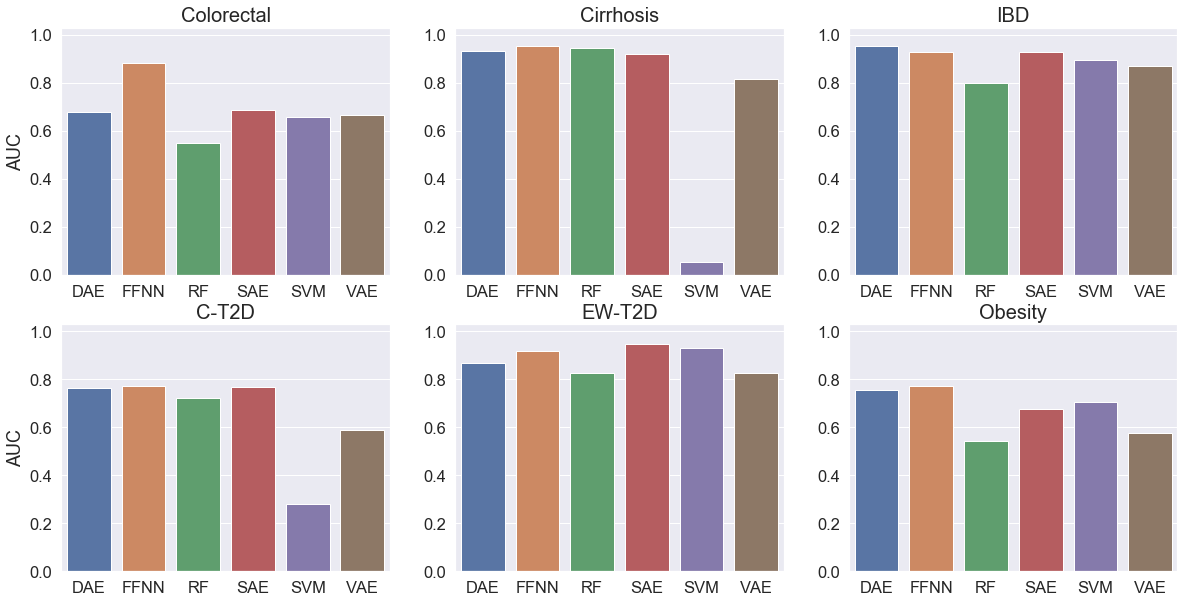

In [12]:
# making some plots like those shown in the paper

datasets=list(all_results.Dataset.unique())
fig, ax = plt.subplots(2, 3, figsize = (20, 10)) 
[plot_fig2_summary(all_results, a, d, 'Marker', i)\
  for i, (d, a) in enumerate( zip(datasets, ax.flatten()[:7]))]
#plt.suptitle('Summary of Marker Dataset Results', size=30)
plt.savefig('figures/marker_results.png')
plt.show()

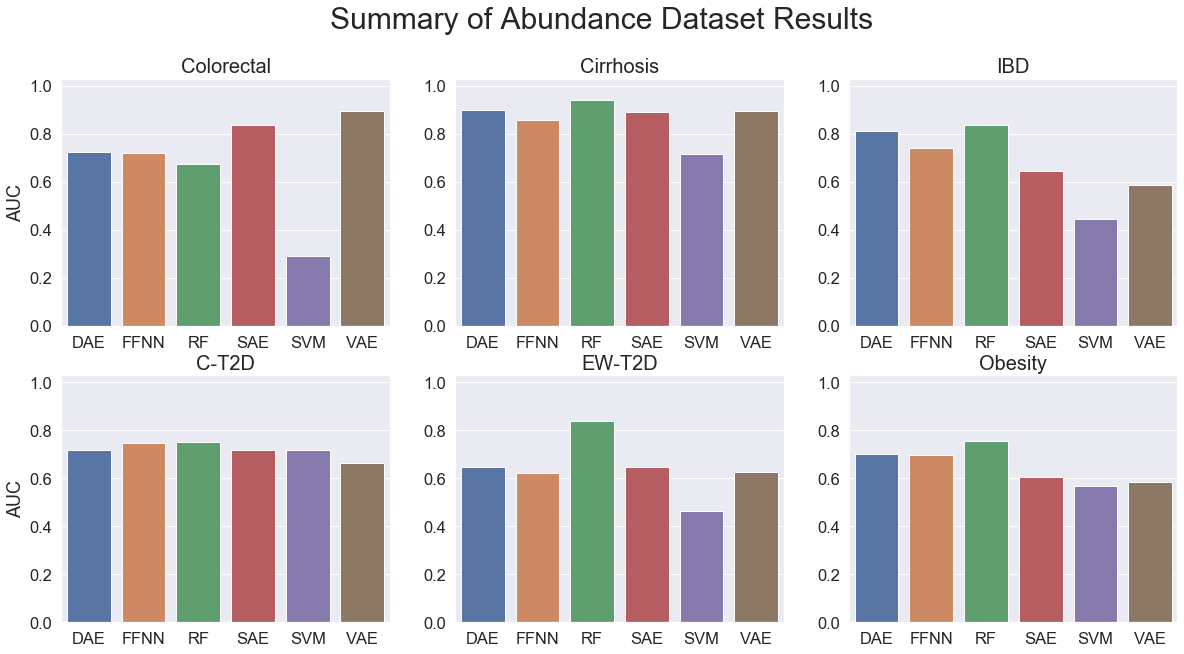

In [13]:
datasets=list(all_results.Dataset.unique())
fig, ax = plt.subplots(2, 3, figsize = (20, 10)) 
[plot_fig2_summary(all_results, a, d, 'Abundance', i)\
  for i, (d, a) in enumerate( zip(datasets, ax.flatten()[:7]) )]
plt.suptitle('Summary of Abundance Dataset Results', size=30)
#plt.savefig('figures/abundance_results.png')
plt.show()